# Compiling COMPASS Jurisdiction GeoPackage

To being with, download the required data:

- State shapefile: https://www2.census.gov/geo/tiger/GENZ2018/shp/cb_2018_us_state_500k.zip
- County shapefile: https://www.census.gov/geographies/mapping-files/time-series/geo/carto-boundary-file.html
- Subdivision shapefile: https://public.opendatasoft.com/explore/dataset/georef-united-states-of-america-county-subdivision/table/?flg=en-us&disjunctive.ste_code&disjunctive.ste_name&disjunctive.coty_code&disjunctive.coty_name&disjunctive.cousub_code&disjunctive.cousub_name&sort=year"
- Info for parish fix: https://transition.fcc.gov/oet/info/maps/census/fips/fips.txt


In [1]:
import ast
from collections import Counter

import pandas as pd
import geopandas as gpd
import matplotlib.pyplot as plt

In [2]:
states = gpd.read_file("cb_2018_us_state_500k")
cnty = gpd.read_file("cb_2018_us_county_500k")
subd = gpd.read_file("georef-united-states-of-america-county-subdivision")

In [3]:
# jurisdictions to remove entirely from collection
remove = [
    'Commonwealth of the Northern Mariana Islands',
    'American Samoa',
    'Guam',
    'Puerto Rico',
    'United States Virgin Islands'
]

## Data conversions

Now that the data is loaded, clean each file and align columns:

In [4]:
check = subd["cousub_name"].values
assert (check[:, 0] == check[:, 1]).all()

In [5]:
subd = subd.loc[:, ~subd.columns.duplicated()].copy()

In [6]:
def _strip_type(row):
    name, j_type = row
    if not j_type:
        return name
    name = name.split(" ")
    if name[-1].casefold() == j_type.casefold():
        name = name[:-1]
    return " ".join(name)


def _clean_county_name(name):
    name = ast.literal_eval(name)
    if len(name) > 1:
        return f"{name[0]} ({name[1]})"
    return name[0]

In [7]:

# clean up names
subd['state_fips'] = subd.ste_code.apply(
    lambda x: pd.to_numeric(ast.literal_eval(x)[0])
)
subd['state_name'] = subd.ste_name.apply(
    lambda x: ast.literal_eval(x)[0]
)
subd['county_fips'] = subd.coty_code.apply(
    lambda x: ast.literal_eval(x)[0][2:]
)
subd['county_name'] = subd.coty_name.apply(
    lambda x: ast.literal_eval(x)[0]
)
subd['subd_name'] = subd.cousub_name.apply(_clean_county_name)
# subd['subd_fips'] = subd.cousub_fp_c
subd['subd_fips'] = subd.cousub_code.apply(
    lambda x: pd.to_numeric(ast.literal_eval(x)[0])
)
subd['subd_type'] = subd.cousub_type
subd['subd_name'] = subd[['subd_name', 'subd_type']].apply(_strip_type, axis=1)

In [8]:
subd = subd[
    [
        'state_name',
        'state_fips',
        'county_fips',
        'county_name',
        'subd_name',
        'subd_fips',
        'subd_type',
        'geometry'
    ]
]

state_fips_table = (
    subd
    .groupby(['state_fips', 'state_name'])
    .first()
    .reset_index()[['state_fips', 'state_name',]]
)
subd = subd[~(subd.state_name.isin(remove))]

In [9]:
# clean up names, transform geom, get names where needed from
# subdivision dataset
cnty['state_fips'] = pd.to_numeric(cnty['STATEFP'])
cnty['county_fips'] = cnty['COUNTYFP']
cnty['county_name'] = cnty['NAME']
cnty['subd_fips'] = cnty['GEOID']
cnty = cnty.to_crs(subd.crs)

cnty = cnty.merge(state_fips_table, on='state_fips', how='left')

In [10]:
cnty = cnty[
    [
        'state_name',
        'state_fips',
        'county_name',
        'county_fips',
        'subd_fips',
        'geometry'
    ]
]
cnty = cnty[~(cnty.state_name.isin(remove))]
cnty["subd_type"] = "county"

In [11]:
states = states[~(states.NAME.isin(remove))].reset_index(drop=True)
states["STATEFP"] = states["STATEFP"].astype(int)
states = states.rename(
    columns={"NAME": "state_name", "STATEFP": "state_fips"}
)
states["subd_fips"] = states["state_fips"] * 1000
states["subd_type"] = "state"
states = states[
    [
        'state_name',
        'state_fips',
        'subd_fips',
        'subd_type',
        'geometry'
    ]
].to_crs(subd.crs)

In [12]:
ord_areas = pd.concat([states, cnty, subd], axis=0, ignore_index=True)
ord_areas = ord_areas[
    [
        'state_name',
        'state_fips',
        'county_name',
        'county_fips',
        'subd_name',
        'subd_fips',
        'subd_type',
        'geometry'
    ]
]
ord_areas = gpd.GeoDataFrame(ord_areas, geometry='geometry', crs=subd.crs)

## Manual cleaning

Now let's manually clean a few known problematic locations


In [13]:
# Manually adjust some entries

ord_areas.loc[ord_areas.subd_fips == "24510", "county_name"] = None
ord_areas.loc[ord_areas.subd_fips == "24510", "subd_name"] = "Baltimore"
ord_areas.loc[ord_areas.subd_fips == "24510", "subd_type"] = "city"

ord_areas.loc[ord_areas.subd_fips == "51600", "county_name"] = None
ord_areas.loc[ord_areas.subd_fips == "51600", "subd_name"] = "Fairfax"
ord_areas.loc[ord_areas.subd_fips == "51600", "subd_type"] = "city"

ord_areas.loc[ord_areas.subd_fips == "51620", "county_name"] = None
ord_areas.loc[ord_areas.subd_fips == "51620", "subd_name"] = "Franklin"
ord_areas.loc[ord_areas.subd_fips == "51620", "subd_type"] = "city"

ord_areas.loc[ord_areas.subd_fips == "51760", "county_name"] = None
ord_areas.loc[ord_areas.subd_fips == "51760", "subd_name"] = "Richmond"
ord_areas.loc[ord_areas.subd_fips == "51760", "subd_type"] = "city"

ord_areas.loc[ord_areas.subd_fips == "51770", "county_name"] = None
ord_areas.loc[ord_areas.subd_fips == "51770", "subd_name"] = "Roanoke"
ord_areas.loc[ord_areas.subd_fips == "51770", "subd_type"] = "city"

ord_areas.loc[ord_areas.subd_fips == "29510", "county_name"] = None
ord_areas.loc[ord_areas.subd_fips == "29510", "subd_name"] = "St. Louis"
ord_areas.loc[ord_areas.subd_fips == "29510", "subd_type"] = "city"

In [14]:
# Fix for parishes, boroughs, and census areas

fips_to_type = pd.read_csv(
    "fips_to_type.txt",
    delimiter="      ",
    header=None,
    names=["fips", "type"],
    dtype={"fips": str, "type": str}
)
mask = fips_to_type["type"].str.lstrip().str.split(" ").apply(len) > 1
fips_to_type = fips_to_type[mask].reset_index(drop=True)
fips_to_type["type"] = (
    fips_to_type["type"]
    .str.lstrip()
    .str.rstrip()
    .str.split(" ")
    .apply(lambda x: x[-1].casefold())
)


parish_fips = set(fips_to_type.loc[fips_to_type["type"] == "parish", "fips"])
parish_mask = ord_areas["subd_fips"].isin(parish_fips)
ord_areas.loc[parish_mask, "subd_type"] = "parish"

fips_borough_mask = (
    (fips_to_type["fips"].str.startswith("02"))
    & (fips_to_type["type"] == "borough")
)
borough_fips = set(fips_to_type.loc[fips_borough_mask, "fips"])
borough_mask = ord_areas["subd_fips"].isin(borough_fips)
ord_areas.loc[borough_mask, "subd_type"] = "borough"

fips_area_mask = (
    (fips_to_type["fips"].str.startswith("02"))
    & (fips_to_type["type"] == "area")
)
area_fips = set(fips_to_type.loc[fips_area_mask, "fips"])
area_mask = ord_areas["subd_fips"].isin(area_fips)
ord_areas.loc[area_mask, "subd_type"] = "census area"

/tmp/ipykernel_4374/3448464197.py:3: ParserWarning: Falling back to the 'python' engine because the 'c' engine does not support regex separators (separators > 1 char and different from '\s+' are interpreted as regex); you can avoid this warning by specifying engine='python'.
  fips_to_type = pd.read_csv(


In [15]:
# Manual Alaska adjustments
ord_areas.loc[ord_areas.subd_fips == "02158", "subd_type"] = "census area"
ord_areas.loc[ord_areas.subd_fips == "02195", "subd_type"] = "borough"
ord_areas.loc[ord_areas.subd_fips == "02230", "subd_type"] = "borough"
ord_areas.loc[ord_areas.subd_fips == "02275", "subd_type"] = "borough"
ord_areas.loc[ord_areas.subd_fips == "02198", "subd_type"] = "census area"
ord_areas.loc[ord_areas.subd_fips == "02105", "subd_type"] = "census area"


ord_areas.loc[ord_areas.subd_fips == "02261", "county_name"] = None
ord_areas.loc[ord_areas.subd_fips == "02261", "subd_name"] = "Valdez-Cordova"
ord_areas.loc[ord_areas.subd_fips == "02261", "subd_type"] = "city"

ord_areas.loc[ord_areas.subd_fips == "02070", "county_name"] = None
ord_areas.loc[ord_areas.subd_fips == "02070", "subd_name"] = "Dillingham"
ord_areas.loc[ord_areas.subd_fips == "02070", "subd_type"] = "city"

ord_areas.loc[ord_areas.subd_fips == "02050", "county_name"] = None
ord_areas.loc[ord_areas.subd_fips == "02050", "subd_name"] = "Bethel"
ord_areas.loc[ord_areas.subd_fips == "02050", "subd_type"] = "city"

ord_areas.loc[ord_areas.subd_fips == "02180", "county_name"] = None
ord_areas.loc[ord_areas.subd_fips == "02180", "subd_name"] = "Nome"
ord_areas.loc[ord_areas.subd_fips == "02180", "subd_type"] = "city"

In [16]:
# Manually adjust shorthand name
ord_areas.loc[ord_areas["subd_type"] == "UT", "subd_type"] = (
    "unorganized territory"
)
ord_areas.loc[ord_areas["subd_type"] == "CCD", "subd_type"] = (
    "census county division"
)

In [17]:
# Drop Ohio census district with duplicate name
ord_areas = ord_areas[~(ord_areas["subd_fips"] == 3915981242)]

In [18]:
known_subd_types = (
    (set(ord_areas["subd_type"]) - {"census county division", None})
    | {"valley", "island"}
)
for ind, row in ord_areas.iterrows():
    if row["subd_type"] != "census county division":
        continue
    split_name = row["subd_name"].split(" ")
    if len(split_name) <= 1:
        ord_areas.loc[ind, "subd_type"] = "city"
        continue

    last_word_in_name = split_name[-1].casefold()
    if last_word_in_name in known_subd_types:
        ord_areas.loc[ind, "subd_type"] = last_word_in_name
        ord_areas.loc[ind, "subd_name"] = " ".join(split_name[:-1])
    elif last_word_in_name in {"lake", "creek"}:
        ord_areas.loc[ind, "subd_type"] = "region"
    else:
        ord_areas.loc[ind, "subd_type"] = "city"

In [19]:
ord_areas.head()

,state_name,state_fips,county_name,county_fips,subd_name,subd_fips,subd_type,geometry
0,Mississippi,28,NaN,NaN,NaN,28000,state,"MULTIPOLYGON (((-88.50297 30.21523, -88.49176 ..."
1,North Carolina,37,NaN,NaN,NaN,37000,state,"MULTIPOLYGON (((-75.7268 35.93584, -75.71826 3..."
2,Oklahoma,40,NaN,NaN,NaN,40000,state,"POLYGON ((-103.00257 36.52659, -103.00219 36.6..."
3,Virginia,51,NaN,NaN,NaN,51000,state,"MULTIPOLYGON (((-75.7424 37.80835, -75.7415 37..."
4,West Virginia,54,NaN,NaN,NaN,54000,state,"POLYGON ((-82.6432 38.16909, -82.643 38.16956,..."


# Final checks

In [20]:
print(ord_areas.subd_type.value_counts())

subd_type
township                 17634
city                      7746
town                      3737
county                    3044
district                  2865
borough                   1240
precinct                   941
village                    541
unorganized territory      301
charter                    118
valley                      70
region                      67
parish                      64
state                       51
reservation                 43
census subarea              37
plantation                  31
island                      29
grant                       10
census area                  6
purchase                     6
gore                         4
location                     4
municipality                 3
Name: count, dtype: int64


In [21]:
assert len(ord_areas["subd_fips"].unique()) == len(ord_areas)
assert len(ord_areas.groupby(["subd_fips"])) == len(ord_areas)

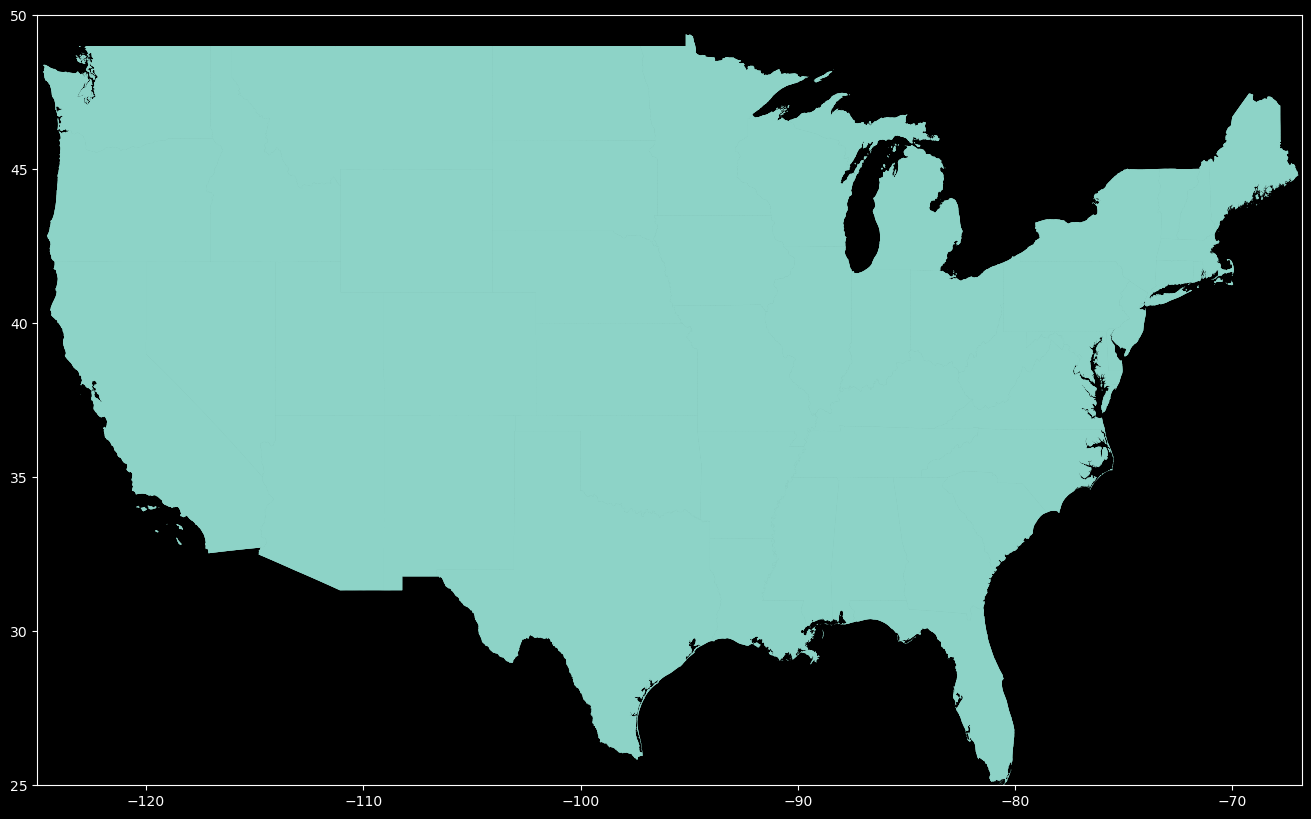

In [21]:
ord_areas.plot(figsize=(20, 10))
plt.xlim(-125, -66.8)
plt.ylim(25, 50);

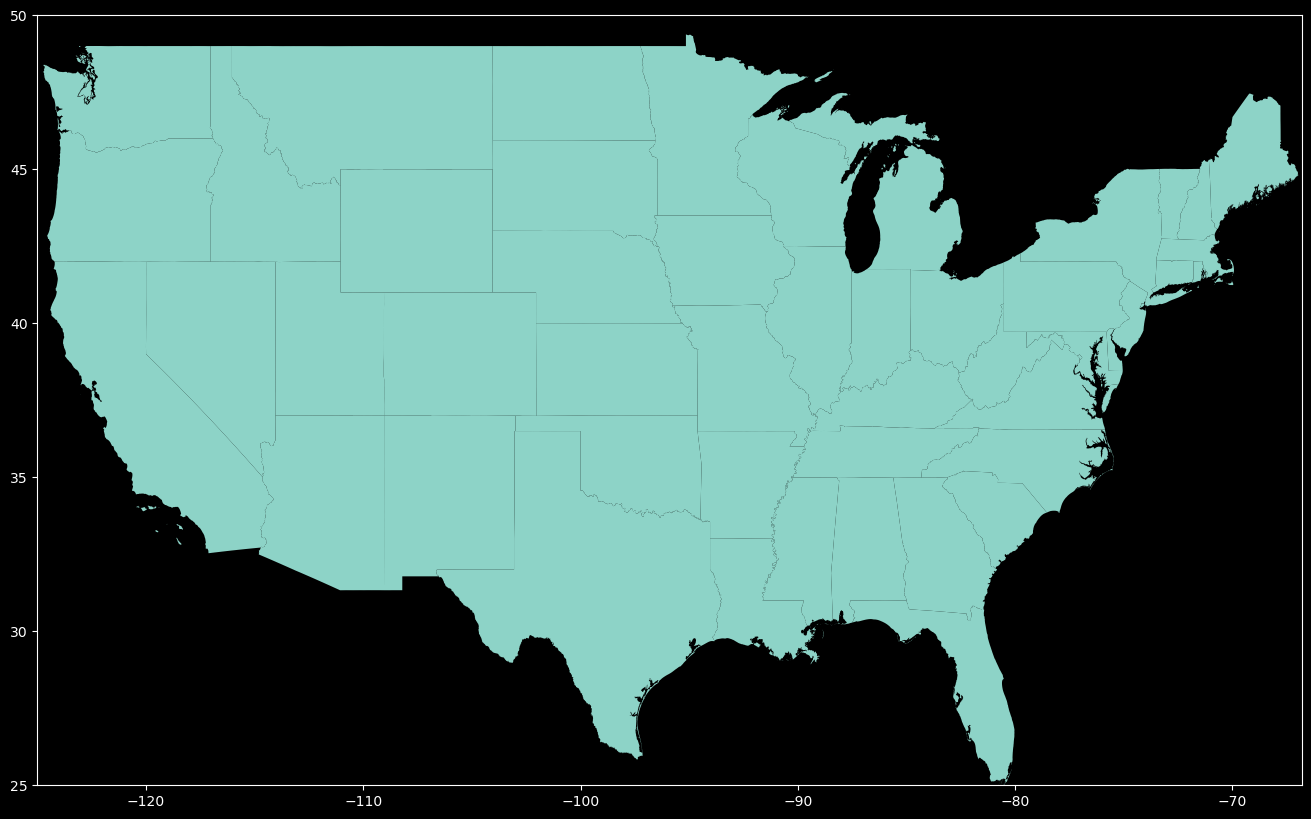

In [22]:
ord_areas[ord_areas["subd_type"] == "state"].plot(figsize=(20, 10))
plt.xlim(-125, -66.8)
plt.ylim(25, 50);

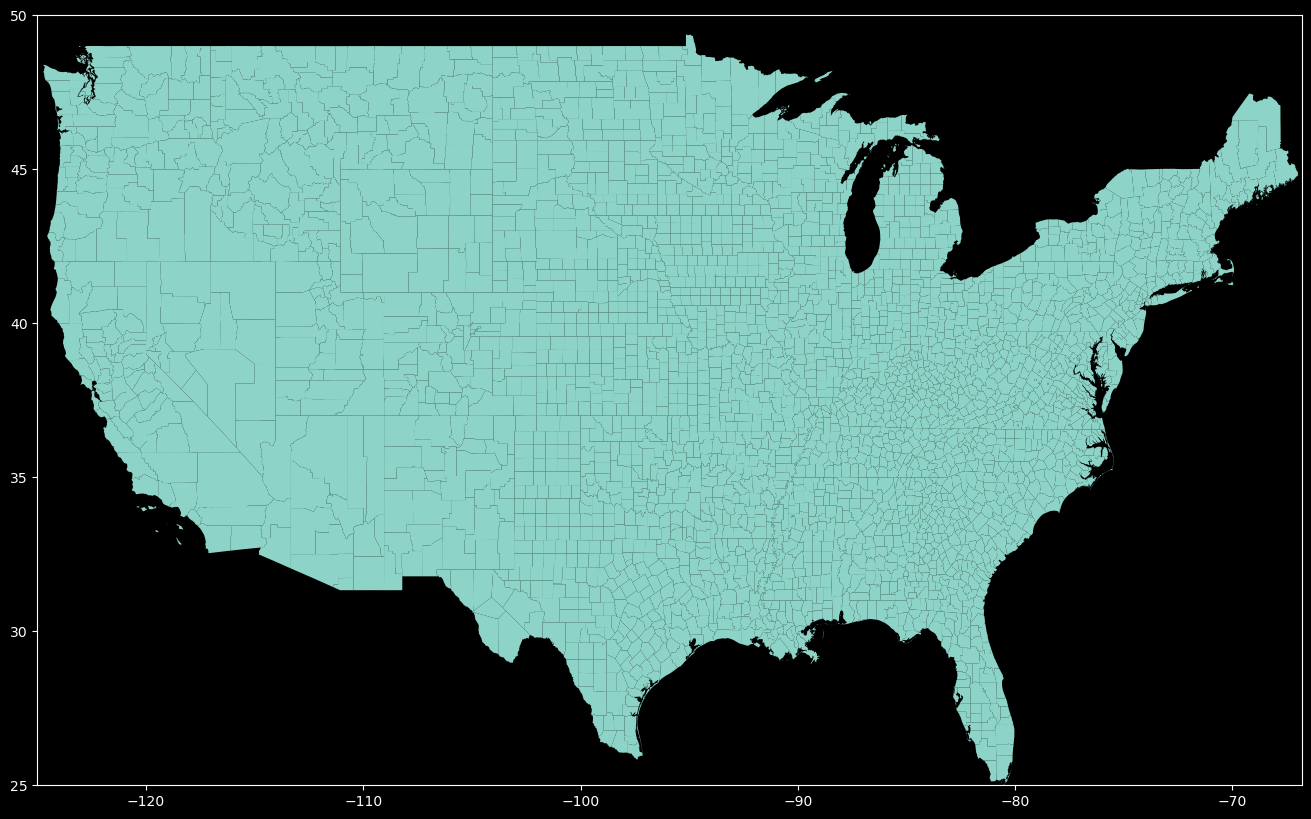

In [23]:
ord_areas[
    (ord_areas["subd_type"] != "state")
    & (ord_areas["subd_fips"].astype(int) < 100_000)
].plot(figsize=(20, 10))
plt.xlim(-125, -66.8)
plt.ylim(25, 50);

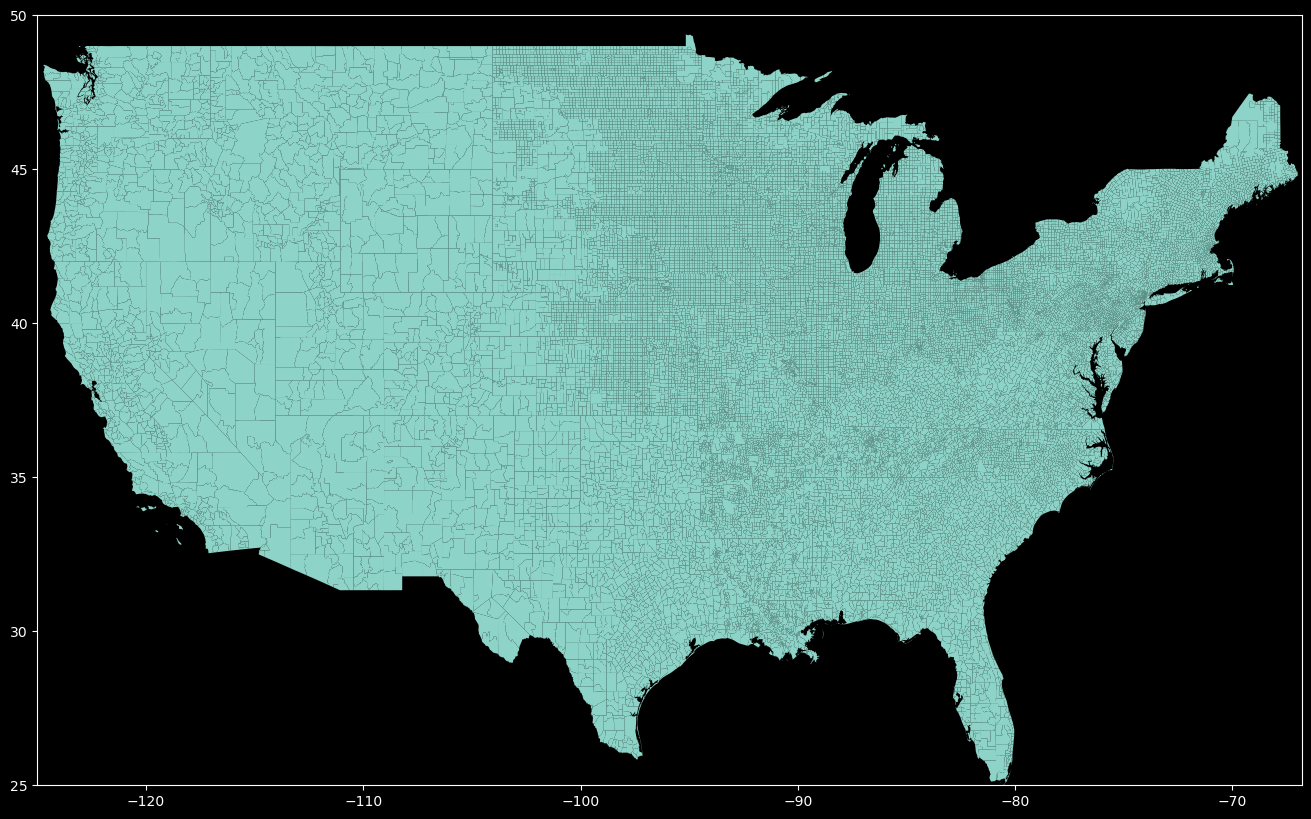

In [22]:
ord_areas[
    (ord_areas["subd_fips"].astype(int) > 100_000)
].plot(figsize=(20, 10))
plt.xlim(-125, -66.8)
plt.ylim(25, 50);

# Export to GeoPackage

In [23]:
ord_areas.to_file("compass_ahjs.gpkg", driver='GPKG')

# Update COMPASS data

In [24]:
all_jurs = ord_areas.drop(columns="geometry")
all_jurs = all_jurs.rename(columns={
    "state_name": "State",
    "county_name": "County",
    "subd_name": "Subdivision",
    "subd_fips": "FIPS",
    "subd_type": "Jurisdiction Type"}
)
existing_websites = pd.read_csv(
    "../compass/data/conus_jurisdictions.csv"
)
all_jurs["FIPS"] = all_jurs["FIPS"].apply(lambda x: f"{x:0>5}")
existing_websites["FIPS"] = existing_websites["FIPS"].apply(
    lambda x: f"{x:0>5}"
)
all_jurs = all_jurs[
    ["State", "County", "Subdivision", "Jurisdiction Type", "FIPS"]
].merge(
    existing_websites,
    on=["State", "County", "Subdivision", "Jurisdiction Type", "FIPS"],
    how="left"
)
assert all_jurs["Website"].any()
all_jurs.sort_values(by=["State", "County", "Subdivision"]).to_csv(
    "../compass/data/conus_jurisdictions.csv",
    index=False
)